In [1]:
from matplotlib import  pyplot as plt
from utils import *
from resnetCIFAR10 import ResNet18
import numpy as np
from attacks import *

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.backends.cudnn as cudnn

dataDir = f'../db'
modelDir = f'./model'
logDir = f'./log'
figDir = f'./fig'
use_cuda = torch.cuda.is_available()
if use_cuda:
    location = 'cuda'
else:
    location = 'cpu'
print(location)

cuda


In [2]:
def vis(net, images, adv_images, labels, figtype='gray', 
                    inv_normalize= None, M = 5, start=50, savename=None, figDir=None):
    """
        create fgsm attach on given images;
        the key parameter is epsilon, which controls the strength of attack
    """
    if not inv_normalize:
        inv_normalize = transforms.Normalize(
                        mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
                        std=[1/0.2023, 1/0.1994, 1/0.2010])
    images_adv = adv_images
    pred_clean = net(simba_utils.apply_normalization(images, 'cifar')).data.max(1)[1]
    pred_adv = net(simba_utils.apply_normalization(images_adv, 'cifar')).data.max(1)[1]
    f,ax = plt.subplots(M,2, sharex=True, sharey=True, figsize=(2,M*1.3))
    for i in range(M):
        for j in range(2):
            if j == 0:
                if figtype == 'gray':
                    ax[i][0].imshow(images[i+start][0].cpu().numpy(), cmap="gray")
                else:
                    ax[i][0].imshow(tensorToImg(images[i+start], inv_normalize))
                title = ax[i][j].set_title(f"{labels[i+start]} -> {pred_clean[i+start]}")
                plt.setp(title, color=('g' if pred_clean[i+start] == labels[i+start] else 'r'))
            else:
                if figtype == 'gray':
                    ax[i][1].imshow(images_adv[i+start][0].cpu().numpy(), cmap="gray")
                else:
                    ax[i][1].imshow(tensorToImg(images_adv[i+start], inv_normalize))
                title = ax[i][j].set_title(f"{labels[i+start]} -> {pred_adv[i+start]}")
                plt.setp(title, color=('g' if pred_adv[i+start] == labels[i+start] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()
    if savename is not None:
        plt.savefig(f'{figDir}/{savename}.png')
        plt.close()

In [3]:
testset = torchvision.datasets.CIFAR10(root=dataDir, train=False, download=False, transform=simba_utils.CIFAR_TRANSFORM)
nTestSamples, width, height, channel = testset.data.shape
image_size = height
print(f'# test samples:{nTestSamples}')
print(f'per image size: {width}*{height} | per image channel:{channel}')

# test samples:10000
per image size: 32*32 | per image channel:3


## Attack on Resnet18 trained on clean data

In [4]:
net = ResNet18()
net.to(location)
net = torch.nn.DataParallel(net)
criterion = torch.nn.CrossEntropyLoss()
netname=f'cifar10-resnet'
modelPath = modelDir+ '/best-{}-checkpoint.pth.tar'.format(netname)
checkpoint = torch.load(modelPath, map_location=torch.device(location))
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### simple demo

In [5]:
result = simba_cifa10(net, testset, num_imgs=16, batch_size=16, image_size=32, order = 'rand', 
                 num_iters = -1, targeted = False, stride = 7, epsilon = 0.2, 
                 linf_bound = 0.0, pixel_attack = True, log_every = 100, return_raw=True)

work on     1/    1...
Iteration 100: queries = 117.8125, prob = 0.5878, remaining = 0.4375
Iteration 200: queries = 167.2500, prob = 0.4890, remaining = 0.2500
Iteration 300: queries = 205.5625, prob = 0.4391, remaining = 0.1875
Iteration 400: queries = 228.0625, prob = 0.3847, remaining = 0.0625
Iteration 500: queries = 238.8750, prob = 0.3829, remaining = 0.0625


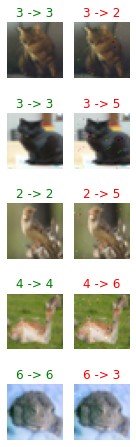

In [6]:
inv_normalize = transforms.Normalize(
                        mean=[0, 0, 0],
                        std=[1, 1, 1])
vis(net, result['raw_images'], result['adv'], result['raw_labels'], figtype='rgb', 
    inv_normalize= inv_normalize, M = 5, start=7)

In [7]:
vis(net, result['raw_images'], result['adv'], result['raw_labels'], figtype='rgb', 
    inv_normalize= inv_normalize, M = 5, start=0, savename=f'simba-cifar10-resnet18', figDir=figDir)

### over the whole dataset

In [5]:
result = simba_cifa10(net, testset, num_imgs=None, batch_size=1000, image_size=32, order = 'rand', 
                 num_iters = -1, targeted = False, stride = 7, epsilon = 0.2, 
                 linf_bound = 0.0, pixel_attack = True, log_every = 1000, return_raw=False)

work on     1/   10...
Iteration 1000: queries = 227.4550, prob = 0.4031, remaining = 0.0040
work on     2/   10...
Iteration 1000: queries = 251.8030, prob = 0.4047, remaining = 0.0100
Iteration 2000: queries = 258.5070, prob = 0.4021, remaining = 0.0020
work on     3/   10...
Iteration 1000: queries = 240.3720, prob = 0.4038, remaining = 0.0150
Iteration 2000: queries = 251.3040, prob = 0.3974, remaining = 0.0020
work on     4/   10...
Iteration 1000: queries = 211.9130, prob = 0.3970, remaining = 0.0040
work on     5/   10...
Iteration 1000: queries = 227.5730, prob = 0.4029, remaining = 0.0120
Iteration 2000: queries = 234.6640, prob = 0.3996, remaining = 0.0010
work on     6/   10...
Iteration 1000: queries = 245.0440, prob = 0.4043, remaining = 0.0080
work on     7/   10...
Iteration 1000: queries = 236.8850, prob = 0.4028, remaining = 0.0070
work on     8/   10...
Iteration 1000: queries = 229.7640, prob = 0.3970, remaining = 0.0140
Iteration 2000: queries = 237.5330, prob = 0.3

In [6]:
selected_result = {}
for key in result.keys():
    if key != 'adv':
        selected_result[key] = result[key]
savefile = f'{modelDir}/{netname}-{0.2}-untargeted.pth'
torch.save(selected_result, savefile)

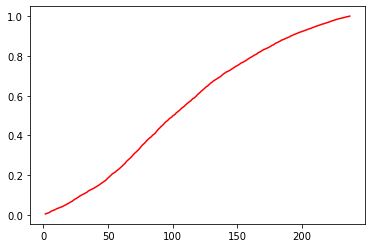

In [14]:
succs, queries = result['succs'], result['queries']
average_query = torch.cumsum(queries, axis=1).mean(0)
plt.plot(average_query, succs.mean(0), 'r-')

## Attack on Resnet18 trained on clean data + adversarail data

In [15]:
net = ResNet18()
net.to(location)
net = torch.nn.DataParallel(net)
criterion = torch.nn.CrossEntropyLoss()
netname=f'cifar10-resnet18-adv-pgd-0.3-0.01-25'
modelPath = modelDir+ '/best-{}-checkpoint.pth.tar'.format(netname)
checkpoint = torch.load(modelPath, map_location=torch.device(location))
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### simple demo

In [16]:
result = simba_cifa10(net, testset, num_imgs=16, batch_size=16, image_size=32, order = 'rand', 
                 num_iters = -1, targeted = False, stride = 7, epsilon = 0.2, 
                 linf_bound = 0.0, pixel_attack = True, log_every = 100, return_raw=True)

work on     1/    1...
Iteration 100: queries = 134.9375, prob = 0.5727, remaining = 0.8125
Iteration 200: queries = 257.6875, prob = 0.5439, remaining = 0.8125
Iteration 300: queries = 379.0000, prob = 0.5132, remaining = 0.8125
Iteration 400: queries = 493.9375, prob = 0.4818, remaining = 0.6875
Iteration 500: queries = 591.8750, prob = 0.4504, remaining = 0.6250
Iteration 600: queries = 681.6250, prob = 0.4171, remaining = 0.5625
Iteration 700: queries = 766.6875, prob = 0.3858, remaining = 0.5625
Iteration 800: queries = 853.1875, prob = 0.3510, remaining = 0.5625
Iteration 900: queries = 939.0625, prob = 0.3258, remaining = 0.5625
Iteration 1000: queries = 1022.4375, prob = 0.3002, remaining = 0.5000
Iteration 1100: queries = 1092.6250, prob = 0.2761, remaining = 0.4375
Iteration 1200: queries = 1153.5000, prob = 0.2610, remaining = 0.2500
Iteration 1300: queries = 1191.5625, prob = 0.2498, remaining = 0.2500
Iteration 1400: queries = 1229.4375, prob = 0.2409, remaining = 0.2500
I

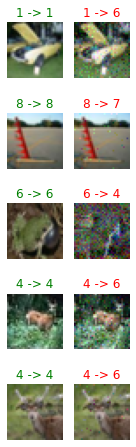

In [17]:
inv_normalize = transforms.Normalize(
                        mean=[0, 0, 0],
                        std=[1, 1, 1])
vis(net, result['raw_images'], result['adv'], result['raw_labels'], figtype='rgb', 
    inv_normalize= inv_normalize, M = 5, start=7)

### over the whole dataset

In [18]:
result = simba_cifa10(net, testset, num_imgs=None, batch_size=1000, image_size=32, order = 'rand', 
                 num_iters = -1, targeted = False, stride = 7, epsilon = 0.2, 
                 linf_bound = 0.0, pixel_attack = True, log_every = 1000, return_raw=False)

work on     1/   10...
Iteration 1000: queries = 964.8310, prob = 0.3272, remaining = 0.3040
Iteration 2000: queries = 1164.3530, prob = 0.2736, remaining = 0.0250
Iteration 3000: queries = 1174.2990, prob = 0.2716, remaining = 0.0010
Iteration 3072: queries = 1174.4351, prob = 0.2716, remaining = 0.0010
work on     2/   10...
Iteration 1000: queries = 994.5090, prob = 0.3358, remaining = 0.3290
Iteration 2000: queries = 1229.1910, prob = 0.2798, remaining = 0.0330
Iteration 3000: queries = 1249.6360, prob = 0.2762, remaining = 0.0050
Iteration 3072: queries = 1250.2209, prob = 0.2761, remaining = 0.0050
work on     3/   10...
Iteration 1000: queries = 992.8110, prob = 0.3414, remaining = 0.3350
Iteration 2000: queries = 1224.8521, prob = 0.2778, remaining = 0.0340
Iteration 3000: queries = 1240.7570, prob = 0.2735, remaining = 0.0020
Iteration 3072: queries = 1240.9510, prob = 0.2735, remaining = 0.0010
work on     4/   10...
Iteration 1000: queries = 973.2840, prob = 0.3224, remainin

In [23]:
selected_result = {}
for key in result.keys():
    if key != 'adv':
        selected_result[key] = result[key]
savefile = f'{modelDir}/{netname}-{0.2}-untargeted.pth'
torch.save(selected_result, savefile)

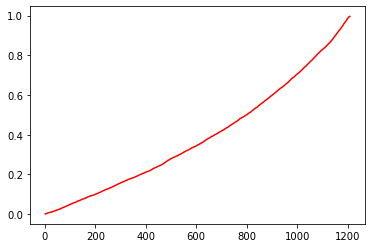

In [20]:
succs, queries = result['succs'], result['queries']
average_query = torch.cumsum(queries, axis=1).mean(0)
plt.plot(average_query, succs.mean(0), 'r-')

In [3]:
clean_res = torch.load(f"{modelDir}/cifar10-resnet-0.2-untargeted.pth")
adv_res = torch.load(f"{modelDir}/cifar10-resnet18-adv-pgd-0.3-0.01-25-0.2-untargeted.pth")

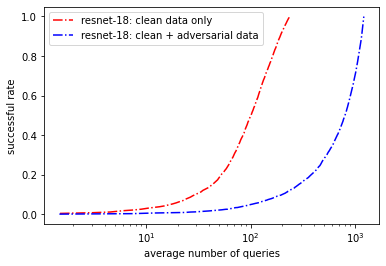

In [11]:
succs_clean, queries_clean = clean_res['succs'], clean_res['queries']
average_query_clean = torch.cumsum(queries_clean, axis=1).mean(0)
succs_adv, queries_adv = adv_res['succs'], adv_res['queries']
average_query_adv = torch.cumsum(queries_adv, axis=1).mean(0)
plt.plot(average_query_clean, succs_clean.mean(0), 'r-.', label='resnet-18: clean data only')
plt.plot(average_query_adv, succs_adv.mean(0), 'b-.', label='resnet-18: clean + adversarial data' )
plt.xscale('log')
plt.legend()
plt.xlabel('average number of queries')
plt.ylabel('successful rate')
plt.savefig('./fig/query-succ.png')